# Table of Contents

1. [Introduction to models]
1. [Evaluating Models](#Evaluating-Models)
 -  [Mean Absolute Error](#Mean-Absolute-Error)
2. [Plot our data]
- [Brute Force](#Brute-Force)
- [Discussion: Optimisation](#Intermezzo:-Optimisation)
- [Linear Regression](#Linear-Regression)
 - [Discussion: Plotting Residuals](#resid)
- [Multiple Linear Regression](#Multiple-Linear-Regression)
- [Feature Engineering](#Feature-Engineering)
 - Encoding Categorical Variables
  - One Hot Encoding
 - Standardization
 - Creating New Features
- XGBoost
- Neural Networks
- Discussion: Hyperparameter Tuning

# Introduction to Models

In traditional programming, we have:

Input + Rules  ->  Output

AI gives us

Input + Expected Output -> Rules


This can lead to effective solutions for problems we don't know how to solve by programming (e.g. recognizing faces.)

The process of working out rules given data is called "training a model". This module is meant to get you up to speed for how to train a model.


There are four key aspects to using models:

1. Evaluation
2. Prediction
3. Training
4. Encoding data.


# Evaluating Models

We'll be using the following data science libraries (click the links for cheat sheets provided by DataCamp)
* [numpy](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)  (for vectorised math operations)
* [pandas](http://datacamp-community.s3.amazonaws.com/9f0f2ae1-8bd8-4302-a67b-e17f3059d9e8) (for dataframes)
* [keras](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) (for neural networks)
* [scikitlearn]

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


The first step to training models is to figure out a way to tell how good a model is. This is similar to test driven development. Before we write our functions, we first define the tests that the functions need to pass. In the world of machine learning, these tests are defined by the data available.

Note that unlike TDD, we don't need to pass all the tests. There will almost always be some difference between the predicted outcome and the measured outcomes.

It's considered good practice to split our data up into a "training set" (for inspection and training models), and a "test set" for model evaluation.

This is to ensure a fair test of the model's ability to generalise to new examples. The same reason why an exam contains different questions to the practice exams a student learns from.


Throughout this module, we'll be using the [Ames Housing Prices Data Set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

The data is described in `../data/housing_price_data/data_description.txt`

In [2]:
labelled = pd.read_csv("../data/housing_price_data/train.csv") #TODO Provide reference to dataset.
labelled.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Examine the size of our data
labelled.shape

(1460, 81)

In [4]:
# Split up into training and test sets.
num_rows = labelled.shape[0]
training_set = labelled[:round(num_rows*0.8)]
test_set = labelled[round(num_rows*0.8):]
training_set.to_csv("../data/housing_price_data/training_data.csv",index = False)
test_set.to_csv("../data/housing_price_data/test_data.csv",index = False)

## Mean Absolute Error
Now that we have a test set, we can evaluate our models!

We'll use the mean absolute error. This is the average size of the difference between the predicted value vs the observed value.

Formally, this is defined as

$$  \mathsf{MAE} = \frac{1}{n} * \sum_{i=1}^n |\mathsf{predicted\_value}[i] - \mathsf{actual\_value}[i]|  $$


We now write a function to evaluate how accurate any given predictive model is at predicting on our test set.


In [5]:
def evaluate_model(model_fn):
    '''
    Consumes a function model_fn
    and evaluates its predictive accuracy against 
    the housing prices test set.
    '''
    test_data = pd.read_csv("../data/housing_price_data/test_data.csv")
    actual_values = test_data['SalePrice']
    test_input = test_data.filter(regex='^(?!SalePrice$).*') #Pass in all columns except SalePrice
    predicted_saleprice = model_fn(test_input)
    mae = np.mean(np.abs(predicted_saleprice-actual_values))
    print("The model is inaccurate by $%.2f on average." % mae)
    return mae

Let's evaluate a very simple predictive heuristic: Sale Price = 100,000 * number of bedrooms.

In [6]:
def bedroom_heuristic(input_data):
    bedrooms = input_data['BedroomAbvGr']
    prediction = 100000*bedrooms
    return(prediction)

In [38]:
evaluate_model(bedroom_heuristic)

The model is inaccurate by $132857.79 on average.


132857.79452054793

Exercise: Try and make a heuristic that achieves a lower score.

Exercise: Extend `evaluate_model` to report how fast the model takes to make its predictions.

# Brute Force

Note that we can easily make new "Bedroom Heuristics" simply by changing the amount of dollars we multiply the number of bedrooms by.

In [8]:
def generate_bedroom_heuristic(a):
    def heuristic(input_data):
        prediction = a * input_data['BedroomAbvGr']
        return(prediction)
    return(heuristic)


The question is now "What's the best amount of dollars to multiply by?" 

Let's start to answer this by using a for loop and trial and error.



In [9]:
model_scores = []
for i in range(200):
    score = evaluate_model(generate_bedroom_heuristic(i*1000))
    model_scores.append(score)

The model is inaccurate by $182244.87 on average.
The model is inaccurate by $179316.79 on average.
The model is inaccurate by $176388.71 on average.
The model is inaccurate by $173460.62 on average.
The model is inaccurate by $170532.54 on average.
The model is inaccurate by $167604.46 on average.
The model is inaccurate by $164676.38 on average.
The model is inaccurate by $161748.29 on average.
The model is inaccurate by $158820.21 on average.
The model is inaccurate by $155892.13 on average.
The model is inaccurate by $152964.05 on average.
The model is inaccurate by $150035.97 on average.
The model is inaccurate by $147107.88 on average.
The model is inaccurate by $144179.80 on average.
The model is inaccurate by $141251.72 on average.
The model is inaccurate by $138323.64 on average.
The model is inaccurate by $135395.55 on average.
The model is inaccurate by $132491.45 on average.
The model is inaccurate by $129590.76 on average.
The model is inaccurate by $126690.08 on average.


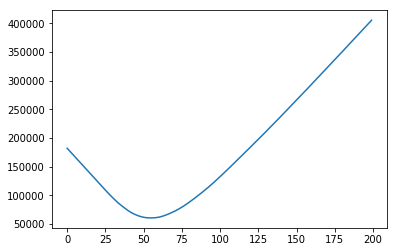

In [10]:
plt.plot(model_scores)
#plt.xaxis("Bedrooms x 1000")
#plt.yaxis("Mean absolute error")
#TODO Label axes.

In [11]:
models = pd.DataFrame()
models['Score'] = model_scores

In [12]:
models.loc[models.Score == models.Score.min()] # Find the minimum score.

,Score
54,60874.363014


One issue with this approach is choosing an appropriate level of granularity. In this example we stepped through increments of 1000. But how do we know the optimal value really is \$54,000 and not \$53,765.08 ? We could lower our step size but this would mean increasing our compute time by orders of magnitude. 

# Intermezzo: Optimisation

The science of doing the above effectively is called optimisation. There are some brilliant algorithms for doing optimisation, the most popular in machine learning is called minibatch gradient descent. You can see an outline of this algorithm [here.](https://cs.brown.edu/courses/csci1951-a/assignments/regression.html)

The idea behind the algorithm is to use calculus. As you may recall from high school maths, when the gradient $dy/dx  = 0$  then y is at a minimum or maximimum. This is illustrated in the following diagram.

<img src="https://cs.brown.edu/courses/csci1951-a/assignments/images/gd.png" width="800">

#TODO: Make our own graph


# Linear Regression

Rather than brute force this, we can use a library.

First, let's define our problem:

*Problem*

Find `a` such that `model_evaluate(generate_bedroom_heuristic(a))` attains a minimum value. 



In other words:

Find `a` such that
`mean(abs(a*training_set['BedroomAbvGr'] - training_set['SalePrice']))` attains a minimum value.

Note that we use the train_data set rather than the test_data set to ensure a better chance of generalisation.

We can solve this problem using the sci-kit-learn library

In [13]:
from sklearn import linear_model

In [14]:
def train_bedroom_linear_model(training_set):
    predictor = linear_model.LinearRegression()
    predictor.fit(training_set[['BedroomAbvGr']],training_set['SalePrice'])
    def bedroom_linear_model(input_data):
        return(predictor.predict(input_data[['BedroomAbvGr']]))
    return bedroom_linear_model

Let's see how well this model does.

In [15]:
bedroom_linear_model = train_bedroom_linear_model(training_set)
evaluate_model(bedroom_linear_model)


The model is inaccurate by $56628.44 on average.


56628.43522624719

Let's examine the differences between predicted and actual value.

In [16]:
bedroom_example = training_set.copy()

In [17]:
bedroom_example['Predicted'] = bedroom_linear_model(bedroom_example)

In [18]:
bedroom_example['Error'] = bedroom_example['Predicted'] - bedroom_example['SalePrice']

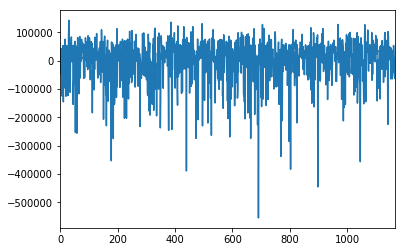

In [19]:
bedroom_example['Error'].plot()  #TODO label axes.

It looks like our model works OK, but there are some instances of severe underprediction.

<TODO: Explain residual plots.>

# Multiple Linear Regression

To remedy this, let's add some more variables into our model. We'll start by adding another numeric variable (living area)

In [20]:
def train_multi_linear_model(training_set):
    def encode_data(data):
        return(data[['BedroomAbvGr','GrLivArea']])
    predictor = linear_model.LinearRegression()
    predictor.fit(encode_data(training_set),training_set['SalePrice'])
    def multi_linear_model(input_data):
        return(predictor.predict(encode_data(input_data)))
    return(multi_linear_model)

In [21]:
multi_linear_model = train_multi_linear_model(training_set)
evaluate_model(multi_linear_model)

The model is inaccurate by $40051.22 on average.


40051.22131205686

## Working with categorical variables
In order to make use of categorical data, we first need to encode it as a number. As a simple example, we'll encode the variable `CentralAir` as 0 if there is no central air conditioning, and 1 if there is central air conditioning. We can do this by using a boolean comparison operation, and relying on the fact that `True == 1`

In [22]:
def train_central_air_model(training_set):
    def encode_data(data):
        features = data.copy()
        features['CentralAir'] = features['CentralAir'] == 'Y'
        features = features[['BedroomAbvGr','GrLivArea','CentralAir']]
        return(features)

    training_features = encode_data(training_set)
    predictor = linear_model.LinearRegression()
    predictor.fit(training_features, training_set['SalePrice'])
    
    def central_air_model(input_data):
        input_features = encode_data(input_data)
        return(predictor.predict(input_features))
    return(central_air_model)

In [23]:
central_air_model = train_central_air_model(training_set)
evaluate_model(central_air_model)

The model is inaccurate by $38058.32 on average.


38058.31999115855

We can deal with categorical variables that have more than two categories in a couple of ways. If the categories follow a clear rank, then we can label them by this rank. An example of this is the basement quality column.

    BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness

We would encode this as Po:1, Fa:2, TA:3, Gd:4, and Ex:5


If there is no order, we use a technique called 'one hot encoding'. This involves creating a new column for each category

For example, the `Electrical` variable in the housing prices dataset contains the following categories:

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

We would encode the table

|Electrical|
|---------|
  |FuseA|
  |FuseF|
  |FuseP|
  |Mix|
  |SBrkr|
  
as

|FuseA |FuseF|FuseP|Mix|SBrkr|
|-----|-----|-----|-----|
| 1| 0  | 0   | 0  | 0  |
| 0|1  | 0   | 0  | 0  |
| 0|0  | 1  | 0| 0|
| 0|0  | 0 | 1 |0 |
| 0|0  | 0 | 0 | 1|

In [24]:
def encode_electrical(electrical):
    one_hot_encoding = pd.DataFrame()
    one_hot_encoding['FuseA'] = electrical == 'FuseA'
    one_hot_encoding['FuseF'] = electrical == 'FuseF'
    one_hot_encoding['FuseP'] = electrical == 'FuseP'
    one_hot_encoding['Mix']   = electrical == 'Mix'
    one_hot_encoding['SBrkr'] = electrical == 'SBrkr'
    return(one_hot_encoding)


In [25]:
encode_electrical(training_set['Electrical']).head(20)

,FuseA,FuseF,FuseP,Mix,SBrkr
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,False,True
5,False,False,False,False,True
6,False,False,False,False,True
7,False,False,False,False,True
8,False,True,False,False,False
9,False,False,False,False,True


Here's an example of using this encoding technique in a linear model.

In [26]:

def train_electrical_model(training_set):
    def encode_data(data):
        return(encode_electrical(data['Electrical']))
    
    training_features = encode_data(training_set)
    predictor = linear_model.LinearRegression()
    predictor.fit(training_features, training_set['SalePrice'])
    
    def electrical_model(input_data):
        input_features = encode_data(input_data)
        return(predictor.predict(input_features))
    return(electrical_model)

In [27]:
electrical_model = train_electrical_model(training_set)
evaluate_model(electrical_model)


The model is inaccurate by $56292.24 on average.


56292.24458339809

Exercise: Pick some columns from the housing prices set, encode them appropriately, and fit a linear model. Try and get the lowest score possible.


## Standardization

Many machine learning algorithms require all variables to be on the same scale, ideally between -1 and 1. Let's compare LotArea to SalePrice

In [28]:
training_set['LotArea'].describe()

count      1168.000000
mean      10521.577055
std       10678.605035
min        1300.000000
25%        7555.000000
50%        9423.000000
75%       11608.500000
max      215245.000000
Name: LotArea, dtype: float64

In [29]:
training_set['SalePrice'].describe()

count      1168.000000
mean     180590.277397
std       78815.697902
min       34900.000000
25%      129900.000000
50%      162950.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Note that the mean (average) of SalePrice is 10 times greater than the mean of LotArea.

We can transform these variables to be on the same scale using a preprocessing trick called _standardization_. We subtract the mean and divide by standard deviation.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
standardizer = StandardScaler()
scaled = pd.DataFrame(standardizer.fit_transform(training_set[['LotArea','SalePrice']]),
             columns=['LotArea','SalePrice'])
scaled.head()

,LotArea,SalePrice
0,-0.194076,0.354265
1,-0.086338,0.011547
2,0.068243,0.544664
3,-0.091022,-0.515223
4,0.350235,0.881036


In [32]:
scaled.describe()

,LotArea,SalePrice
count,1.168000e+03,1.168000e+03
mean,-8.430934e-17,-2.378710e-17
std,1.000428e+00,1.000428e+00
min,-8.639262e-01,-1.849285e+00
25%,-2.779247e-01,-6.434250e-01
50%,-1.029205e-01,-2.239127e-01
75%,1.018287e-01,4.240784e-01
max,1.917958e+01,7.291133e+00


We can put these back to their original scale using the `inverse_transform` method.

In [33]:
pd.DataFrame(standardizer.inverse_transform(scaled),
             columns=["LotArea","SalePrice"]).head()

,LotArea,SalePrice
0,8450.0,208500.0
1,9600.0,181500.0
2,11250.0,223500.0
3,9550.0,140000.0
4,14260.0,250000.0


In [34]:
training_set[['LotArea',"SalePrice"]].head()

,LotArea,SalePrice
0,8450,208500
1,9600,181500
2,11250,223500
3,9550,140000
4,14260,250000


## Creating New Features

We can also add new features to our model by combining two or more existing features. For example, let's
multiply bedrooms by bathrooms. 
We'll also standardize our input and output.

In [98]:
def train_bedroom_bathroom_model(training_set):
    def encode_data(data,scaler = None):
        data = data.copy()
        data = data[['FullBath','BedroomAbvGr']]
        data['BedBath'] = data['FullBath'] * data['BedroomAbvGr']
        
        if(not scaler):
            scaler = StandardScaler()
            scaler.fit(data)
        pd.DataFrame(scaler.transform(data), columns = ['FullBath','BedroomAbvGr','BedBath'])
        return(data,scaler)
    
    training_features, scaler = encode_data(training_set)
    predictor = linear_model.LinearRegression()
    predictor.fit(training_features, training_set['SalePrice'])
    
    def bedroom_bathroom_model(input_data):
        input_features,_ = encode_data(input_data,scaler)
        predictions = predictor.predict(input_features)
        return(predictions)
    return(bedroom_bathroom_model)

In [99]:
bedroom_bathroom_model = train_bedroom_bathroom_model(training_set)

In [100]:
evaluate_model(bedroom_bathroom_model)

The model is inaccurate by $47140.90 on average.


47140.89624339486

# The SciKit API


We now have a sense of the workflow necessary to use machine learning models.

The steps we take are:

1. _feature engineering_: Encode all the data we want to use into numbers. Perform any other transformations you think are necessary (e.g. scaling). We end up with a 2D array `X_train` containing all the columns we want to process, as well as an array `y_train` containing the column we want to predict (possibly scaled)

2. _train our model_:  This can be done with the command `model.fit(X_train,y_train)`

3. _predict_: Use our freshly trained model to make some predictions.  This is done with the command `model.predict(input)``

4. _evaluate_: We can use the `evaluate_model` function.

# Random Forests





Now that we understand how to preprocess our data, we can use any other model in scikitlearn. We'll use XGBoost, a model that has won many kaggle competitions. 


In [117]:
import xgboost

In [120]:
def train_xgboost_model(training_set):
    def encode_data(data,scaler = None):
        data = data.copy()
        data = data[['FullBath','BedroomAbvGr']]
        data['BedBath'] = data['FullBath'] * data['BedroomAbvGr']
        
        if(not scaler):
            scaler = StandardScaler()
            scaler.fit(data)
        pd.DataFrame(scaler.transform(data), columns = ['FullBath','BedroomAbvGr','BedBath'])
        return(data,scaler)
    
    training_features, scaler = encode_data(training_set)
    predictor = xgboost.XGBRegressor()
    predictor.fit(training_features, training_set['SalePrice'])
    
    def xgboost_model(input_data):
        input_features,_ = encode_data(input_data,scaler)
        predictions = predictor.predict(input_features)
        return(predictions)
    return(xgboost_model)

In [121]:
xgboost_model = train_xgboost_model(training_set)
evaluate_model(xgboost_model)

The model is inaccurate by $45394.72 on average.


45394.71813463185

# Neural Networks

Now that we 

In [148]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import sklearn

In [178]:
def train_neural_network_model(training_set):
    def encode_data(data,scaler = None):
        data = data.copy()
        data = data[['FullBath','BedroomAbvGr']]
        data['BedBath'] = data['FullBath'] * data['BedroomAbvGr']
        
        if(not scaler):
            scaler = StandardScaler()
            scaler.fit(data)
        pd.DataFrame(scaler.transform(data), columns = ['FullBath','BedroomAbvGr','BedBath'])
        return(data,scaler)
    
    training_features, scaler = encode_data(training_set)
    
    predictor = model = Sequential([
    Dense(32, input_shape=(3,)),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(1),
    Activation('relu')
    ])
    
    predictor.compile(optimizer='rmsprop',
              loss='mae')
    
    label_scaler = sklearn.preprocessing.MinMaxScaler()
    scaled_labels = label_scaler.fit_transform(training_set[['SalePrice']])
    predictor.fit(training_features,scaled_labels, epochs = 50)
    
    def neural_network_model(input_data):
        input_features,_ = encode_data(input_data,scaler)
        scaled_predictions = predictor.predict(input_features)
        
        # Descale the prediction.
        predictions = pd.DataFrame(label_scaler.inverse_transform(scaled_predictions),
                                   columns = ["SalePrice"])
        
        return(predictions['SalePrice'])
    return(neural_network_model)

In [179]:
neural_network_model = train_neural_network_model(training_set)


Epoch 1/50
1168/1168 [==============================] - 1s 443us/step - loss: 0.0781
Epoch 2/50
1168/1168 [==============================] - 0s 46us/step - loss: 0.0687
Epoch 3/50
1168/1168 [==============================] - 0s 46us/step - loss: 0.0672
Epoch 4/50
1168/1168 [==============================] - 0s 51us/step - loss: 0.0669
Epoch 5/50
1168/1168 [==============================] - 0s 58us/step - loss: 0.0660
Epoch 6/50
1168/1168 [==============================] - 0s 117us/step - loss: 0.0650
Epoch 7/50
1168/1168 [==============================] - 0s 99us/step - loss: 0.0660
Epoch 8/50
1168/1168 [==============================] - 0s 82us/step - loss: 0.0652
Epoch 9/50
1168/1168 [==============================] - 0s 84us/step - loss: 0.0636
Epoch 10/50
1168/1168 [==============================] - 0s 58us/step - loss: 0.0642
Epoch 11/50
1168/1168 [==============================] - 0s 44us/step - loss: 0.0634
Epoch 12/50
1168/1168 [==============================] - 0s 45us/step - 

In [180]:
evaluate_model(neural_network_model)

The model is inaccurate by $44488.91 on average.


44488.912323416094

# Discussion: Hyperparameter Tuning

If we browse the docs for [xgboost](http://xgboost.readthedocs.io/en/latest/) and [keras](https://keras.io), we find that there are a lot of different parameters we can set. You might be wondering how to decide which ones to use.

You should view these parameters as knobs you can twiddle. The truth is you'll have to figure out what the best parameters to set are through trial and error. Just try lots of different combinations and see which one performs the best.

There is research into automating this process. The problem has been dubbed "hyperparameter optimisation."

